In [123]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=(FutureWarning))

In [125]:
defense = pd.read_csv("../match_logs/Big5@22-23@defense.csv")
gca = pd.read_csv("../match_logs/Big5@22-23@gca.csv")
keeper = pd.read_csv("../match_logs/Big5@22-23@keeper.csv")
misc = pd.read_csv("../match_logs/Big5@22-23@misc.csv")
passing = pd.read_csv("../match_logs/Big5@22-23@passing.csv")
passing_types = pd.read_csv("../match_logs/Big5@22-23@passing_types.csv")
possession = pd.read_csv("../match_logs/Big5@22-23@possession.csv")
shooting = pd.read_csv("../match_logs/Big5@22-23@shooting.csv")

In [166]:
team_ratings = pd.read_csv("../players_db/fm23/team_ratings.csv")

<br><br><br><br><br><br><br><br>
<h1 style="color:orange;background:blue;">1.  Shot Creating Actions</h1>

In [127]:
gca.columns

Index(['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'SCA', 'PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def',
       'GCA', 'PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1',
       'Match Report', 'Club'],
      dtype='object')

In [128]:
gca_cols = ["SCA", "PassLive", "PassDead", "TO", "Sh", "Fld", "Def", "GCA", "PassLive.1", "PassDead.1", "TO.1", "Sh.1", "Fld.1", "Def.1" ]

In [129]:
gca[gca_cols].describe().loc[['min', 'mean', 'max']]

,SCA,PassLive,PassDead,TO,Sh,Fld,Def,GCA,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
mean,21.815545,15.804324,1.974001,1.238916,1.353038,1.087028,0.358238,2.299398,1.609195,0.141215,0.159278,0.203339,0.151341,0.03503
max,66.000000,49.000000,10.000000,9.000000,10.000000,6.000000,4.000000,14.000000,11.000000,3.000000,5.000000,3.000000,3.000000,3.00000


In [130]:
merged_df = pd.merge(gca, team_ratings, on="Club", how="inner")  
merged_df = pd.merge(merged_df, team_ratings, left_on="Opponent", right_on="fbref_name", how="inner")  
merged_df.dropna(inplace=True)

In [131]:
tpr_cols = ['tpr_x', 'gk_x', 'def_x', 'pas_x', 'dri_x', 'fin_x', 'sta_x', 'str_x', 'hed_x', 'men_x', 'iq_x','tpr_y', 'gk_y', 'def_y', 'pas_y', 'dri_y', 'fin_y', 'sta_y', 'str_y', 'hed_y', 'men_y', 'iq_y']
reg_df = merged_df[['Club_x','Club_y'] + gca_cols + tpr_cols] #.describe().loc[['min', 'mean', 'max']]
reg_df.iloc[45]

Club_x        Tottenham Hotspur
Club_y              Bournemouth
SCA                        40.0
PassLive                   30.0
PassDead                    4.0
TO                          1.0
Sh                          4.0
Fld                         1.0
Def                         0.0
GCA                         2.0
PassLive.1                  2.0
PassDead.1                  0.0
TO.1                        0.0
Sh.1                        0.0
Fld.1                       0.0
Def.1                       0.0
tpr_x                        84
gk_x                         62
def_x                        71
pas_x                        73
dri_x                        72
fin_x                        76
sta_x                        83
str_x                        79
hed_x                        76
men_x                        71
iq_x                         70
tpr_y                        78
gk_y                         63
def_y                        65
pas_y                        66
dri_y   

<br><br><br><br><br><br><br><br>
<h3 style="color:white;background:red;">  Regression - gca</h3>

In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [133]:
reg_tpr_cols = ["tpr_x","pas_x","hed_x","dri_x","tpr_y","def_y"]
formula_df = pd.DataFrame(index=reg_tpr_cols)
np.random.seed(0)
df = reg_df

for attribute in gca_cols:
    X = df[reg_tpr_cols]
    Y = df[[attribute]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    coef_column_name = f"{attribute}_coef"
    intercept_column_name = f"{attribute}_intercept"
    formula_df[coef_column_name] = model.coef_.flatten()
    formula_df[intercept_column_name] = model.intercept_[0]

    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    # print(f'Mean Squared Error: {mse}')
    # print(f'R^2 Score: {r2}')

In [134]:
formula_df

,SCA_coef,SCA_intercept,PassLive_coef,PassLive_intercept,PassDead_coef,PassDead_intercept,TO_coef,TO_intercept,Sh_coef,Sh_intercept,...,PassDead.1_coef,PassDead.1_intercept,TO.1_coef,TO.1_intercept,Sh.1_coef,Sh.1_intercept,Fld.1_coef,Fld.1_intercept,Def.1_coef,Def.1_intercept
tpr_x,0.498662,7.920159,0.378052,-2.219837,0.046625,5.122325,-0.019907,2.381476,0.047590,-0.143785,...,0.002930,0.528465,-0.003299,0.774474,0.004952,0.275008,0.011678,0.362357,0.009963,-0.336725
pas_x,0.037378,7.920159,0.069815,-2.219837,-0.026765,5.122325,0.014054,2.381476,-0.002697,-0.143785,...,-0.001409,0.528465,0.002841,0.774474,0.000823,0.275008,-0.001639,0.362357,-0.002399,-0.336725
hed_x,0.024687,7.920159,0.010002,-2.219837,0.031591,5.122325,-0.014474,2.381476,0.000523,-0.143785,...,0.002339,0.528465,-0.003918,0.774474,-0.005037,0.275008,-0.003401,0.362357,-0.004048,-0.336725
dri_x,0.469739,7.920159,0.388287,-2.219837,-0.012680,5.122325,0.064960,2.381476,0.034950,-0.143785,...,-0.000908,0.528465,0.016398,0.774474,0.011023,0.275008,-0.002426,0.362357,-0.001172,-0.336725
tpr_y,-0.863637,7.920159,-0.569705,-2.219837,-0.112685,5.122325,-0.065391,2.381476,-0.080061,-0.143785,...,-0.012031,0.528465,-0.022870,0.774474,-0.016172,0.275008,-0.006281,0.362357,0.003070,-0.336725
def_y,0.089091,7.920159,0.010761,-2.219837,0.038929,5.122325,0.018111,2.381476,0.026918,-0.143785,...,0.004886,0.528465,0.006206,0.774474,0.005447,0.275008,-0.001706,0.362357,-0.002026,-0.336725


In [135]:
attribute = "PassLive"

In [136]:
custom_tpr_df = pd.DataFrame({
 'tpr_x': 78,
 'pas_x': 90,
 'hed_x': 66,
 'dri_x': 68,
 'tpr_y': 79,
 'def_y': 63}.values(), columns=["custom"], index=reg_tpr_cols)

In [137]:
custom_tpr_df[f"{attribute}_coef"] = formula_df[f"{attribute}_coef"].tolist()
custom_tpr_df[f"{attribute}_intercept"] = formula_df[f"{attribute}_intercept"].tolist()
custom_tpr_df["coef_result"] = custom_tpr_df[f"{attribute}_coef"] * custom_tpr_df["custom"]
custom_tpr_df["formula_result"] = custom_tpr_df["coef_result"].sum() + custom_tpr_df[f"{attribute}_intercept"].iloc[0]
custom_tpr_df["formula_result"] = round(custom_tpr_df["formula_result"].iloc[0])

In [138]:
custom_tpr_df

,custom,PassLive_coef,PassLive_intercept,coef_result,formula_result
tpr_x,78,0.378052,-2.219837,29.488022,16
pas_x,90,0.069815,-2.219837,6.283370,16
hed_x,66,0.010002,-2.219837,0.660162,16
dri_x,68,0.388287,-2.219837,26.403547,16
tpr_y,79,-0.569705,-2.219837,-45.006715,16
def_y,63,0.010761,-2.219837,0.677930,16


In [139]:
formula_df[["GCA_coef","GCA_intercept"]]

,GCA_coef,GCA_intercept
tpr_x,0.209243,-1.67402
pas_x,0.000738,-1.67402
hed_x,-0.066262,-1.67402
dri_x,0.041845,-1.67402
tpr_y,-0.124040,-1.67402
def_y,-0.016278,-1.67402


In [140]:
merged_df.iloc[155]

Date                            2023-04-22
Time                                 15:00
Round                         Matchweek 32
Day                                    Sat
Venue                                 Home
Result                                   W
GF                                     3.0
GA                                     2.0
Opponent                   Nott'ham Forest
SCA                                   32.0
PassLive                              12.0
PassDead                               8.0
TO                                     1.0
Sh                                     5.0
Fld                                    6.0
Def                                    0.0
GCA                                    6.0
PassLive.1                             2.0
PassDead.1                             2.0
TO.1                                   0.0
Sh.1                                   0.0
Fld.1                                  2.0
Def.1                                  0.0
Match Repor

<br><br><br><br><br><br><br><br>
<h1 style="color:orange;background:blue;">  2. Passing</h1>

In [141]:
passing.columns

Index(['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1',
       'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3',
       'Cmp%.3', 'Ast', 'xAG', 'xA', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP',
       'Match Report', 'Club'],
      dtype='object')

In [142]:
passing_cols = ['GF', 'GA','Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1',
       'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3',
       'Cmp%.3', 'Ast', 'xAG', 'xA', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

In [143]:
passing[passing_cols].describe().loc[['min', 'mean', 'max', 'std']]

,GF,GA,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,...,Att.3,Cmp%.3,Ast,xAG,xA,KP,1/3,PPA,CrsPA,PrgP
min,0.000000,0.000000,75.000000,181.000000,40.500000,1780.000000,969.000000,24.000000,41.000000,58.500000,...,31.000000,22.200000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,6.000000
mean,1.383415,1.383415,385.380131,487.238643,77.733552,6879.948823,2508.184182,171.493158,195.857964,86.458402,...,75.154351,54.555665,0.931856,0.986344,0.930679,9.295293,29.978927,7.788451,2.065955,37.626984
max,9.000000,9.000000,817.000000,917.000000,93.300000,14475.000000,4536.000000,494.000000,517.000000,97.400000,...,146.000000,88.400000,6.000000,4.200000,4.700000,29.000000,98.000000,30.000000,12.000000,110.000000
std,1.246494,1.246494,122.841598,121.225244,6.954288,1993.397218,492.841417,63.844338,65.120620,5.184912,...,14.273913,10.597963,1.027947,0.608685,0.555571,4.188561,13.117166,4.275212,1.726836,15.059428


In [144]:
merged_df = pd.merge(passing, team_ratings, on="Club", how="inner")  
merged_df = pd.merge(merged_df, team_ratings, left_on="Opponent", right_on="fbref_name", how="inner")  
merged_df.dropna(inplace=True)

In [145]:
tpr_cols = ['tpr_x', 'gk_x', 'def_x', 'pas_x', 'dri_x', 'fin_x', 'sta_x', 'str_x', 'hed_x', 'men_x', 'iq_x','tpr_y', 'gk_y', 'def_y', 'pas_y', 'dri_y', 'fin_y', 'sta_y', 'str_y', 'hed_y', 'men_y', 'iq_y']
reg_df = merged_df[['Club_x','Club_y'] + passing_cols + tpr_cols] #.describe().loc[['min', 'mean', 'max']]
reg_df.iloc[45]

Club_x     Tottenham Hotspur
Club_y           Bournemouth
GF                       2.0
GA                       3.0
Cmp                    421.0
Att                    543.0
Cmp%                    77.5
TotDist               7150.0
PrgDist               2199.0
Cmp.1                  223.0
Att.1                  255.0
Cmp%.1                  87.5
Cmp.2                  150.0
Att.2                  187.0
Cmp%.2                  80.2
Cmp.3                   42.0
Att.3                   74.0
Cmp%.3                  56.8
Ast                      1.0
xAG                      1.8
xA                       1.6
KP                      16.0
1/3                     36.0
PPA                     10.0
CrsPA                    6.0
PrgP                    40.0
tpr_x                     84
gk_x                      62
def_x                     71
pas_x                     73
dri_x                     72
fin_x                     76
sta_x                     83
str_x                     79
hed_x         

<br><br><br><br><br><br><br><br>
<h3 style="color:white;background:red;">  Regression - passing</h3>

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [147]:
reg_tpr_cols = ["tpr_x","pas_x","tpr_y","def_y"]
formula_df = pd.DataFrame(index=reg_tpr_cols)
np.random.seed(0)
df = reg_df

for attribute in passing_cols:
    X = df[reg_tpr_cols]
    Y = df[[attribute]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    coef_column_name = f"{attribute}_coef"
    intercept_column_name = f"{attribute}_intercept"
    formula_df[coef_column_name] = model.coef_.flatten()
    formula_df[intercept_column_name] = model.intercept_[0]

    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    # print(f'Mean Squared Error: {mse}')
    # print(f'R^2 Score: {r2}')

In [148]:
formula_df.T

,tpr_x,pas_x,tpr_y,def_y
GF_coef,0.081848,0.019230,-0.068971,-0.015833
GF_intercept,0.085123,0.085123,0.085123,0.085123
GA_coef,-0.061534,-0.016745,0.119302,-0.011592
GA_intercept,-1.309077,-1.309077,-1.309077,-1.309077
Cmp_coef,13.132978,6.567974,-10.467070,0.658561
Cmp_intercept,-326.125927,-326.125927,-326.125927,-326.125927
Att_coef,13.775673,5.164065,-13.942834,2.882021
Att_intercept,-49.625096,-49.625096,-49.625096,-49.625096
Cmp%_coef,0.442269,0.479694,0.105601,-0.350869
Cmp%_intercept,24.261257,24.261257,24.261257,24.261257


In [149]:
attribute = "Att"

In [150]:
team_ratings

,Club,Club_id,League_id,Division,Based,tpr,gk,def,pas,dri,fin,sta,str,hed,men,iq,fbref_name
0,Manchester City,6827,354,English Premier Division,England (Premier Division),88,73,74,80,77,76,83,78,71,77,77,Manchester City
1,Paris Saint-Germain,7994,773,Ligue 1 Uber Eats,France (Ligue 1 Uber Eats),88,67,71,82,80,74,76,75,73,74,80,Paris S-G
2,Internazionale,5215,710,Italian Serie A,Italy (Serie A),86,67,74,75,72,75,81,84,82,71,72,Inter
3,Liverpool,6518,354,English Premier Division,England (Premier Division),86,74,73,78,77,72,83,77,77,75,75,Liverpool
4,FC Barcelona,1435,1215,Spanish First Division,Spain (First Division),86,75,72,76,76,75,81,77,77,77,78,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,FC Volendam,3948,363,Eredivisie,Holland (Eredivisie),72,55,58,61,62,55,61,61,66,59,60,NaN
149,Go Ahead,4469,363,Eredivisie,Holland (Eredivisie),72,59,59,61,64,55,66,66,61,60,59,NaN
150,Cambuur,9344,363,Eredivisie,Holland (Eredivisie),71,55,57,59,63,56,66,64,64,62,61,NaN
151,RKC,8812,363,Eredivisie,Holland (Eredivisie),71,53,56,60,63,54,63,66,60,61,58,NaN


In [158]:
the_team_X = team_ratings.query("Club == 'Manchester City'").iloc[0]
the_team_Y = team_ratings.query("Club == 'Liverpool'").iloc[0]

In [159]:
custom_tpr_df = pd.DataFrame({
 'tpr_x': the_team_X["tpr"],
 'pas_x': the_team_X["pas"],
 'tpr_y': the_team_Y["tpr"],
 'def_y': the_team_Y["def"]}.values(), columns=["custom"], index=reg_tpr_cols)

In [160]:
custom_tpr_df[f"{attribute}_coef"] = formula_df[f"{attribute}_coef"].tolist()
custom_tpr_df[f"{attribute}_intercept"] = formula_df[f"{attribute}_intercept"].tolist()
custom_tpr_df["coef_result"] = custom_tpr_df[f"{attribute}_coef"] * custom_tpr_df["custom"]
custom_tpr_df["formula_result"] = custom_tpr_df["coef_result"].sum() + custom_tpr_df[f"{attribute}_intercept"].iloc[0]
custom_tpr_df["formula_result"] = round(custom_tpr_df["formula_result"].iloc[0])

In [161]:
custom_tpr_df

,custom,Att_coef,Att_intercept,coef_result,formula_result
tpr_x,88,13.775673,-49.625096,1212.259214,587
pas_x,80,5.164065,-49.625096,413.125237,587
tpr_y,86,-13.942834,-49.625096,-1199.083736,587
def_y,73,2.882021,-49.625096,210.387564,587


In [155]:
reg_df.select_dtypes(exclude="object").apply(lambda x: round((x/90), 2))

,GF,GA,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,...,gk_y,def_y,pas_y,dri_y,fin_y,sta_y,str_y,hed_y,men_y,iq_y
0,0.02,0.00,8.80,9.66,1.01,142.10,44.21,4.61,4.78,1.07,...,0.69,0.81,0.78,0.79,0.78,0.89,0.89,0.91,0.81,0.76
1,0.03,0.00,7.54,8.54,0.98,123.76,33.37,3.48,3.74,1.03,...,0.69,0.81,0.78,0.79,0.78,0.89,0.89,0.91,0.81,0.76
2,0.01,0.00,5.96,7.10,0.93,92.33,33.69,2.84,3.12,1.01,...,0.69,0.81,0.78,0.79,0.78,0.89,0.89,0.91,0.81,0.76
3,0.02,0.01,8.53,9.82,0.97,133.27,44.02,4.58,4.97,1.02,...,0.69,0.81,0.78,0.79,0.78,0.89,0.89,0.91,0.81,0.76
4,0.01,0.00,4.69,5.79,0.90,77.79,25.04,2.31,2.52,1.02,...,0.69,0.81,0.78,0.79,0.78,0.89,0.89,0.91,0.81,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759,0.00,0.03,2.69,3.98,0.75,53.96,28.89,1.23,1.51,0.91,...,0.81,0.79,0.83,0.87,0.76,0.94,0.88,0.79,0.83,0.83
3760,0.01,0.07,3.71,4.80,0.86,67.36,25.01,1.64,1.87,0.98,...,0.81,0.79,0.83,0.87,0.76,0.94,0.88,0.79,0.83,0.83
3761,0.01,0.02,2.91,4.02,0.80,55.50,23.68,1.21,1.49,0.90,...,0.81,0.79,0.83,0.87,0.76,0.94,0.88,0.79,0.83,0.83
3762,0.01,0.00,1.18,2.61,0.50,30.57,23.00,0.39,0.62,0.69,...,0.81,0.79,0.83,0.87,0.76,0.94,0.88,0.79,0.83,0.83


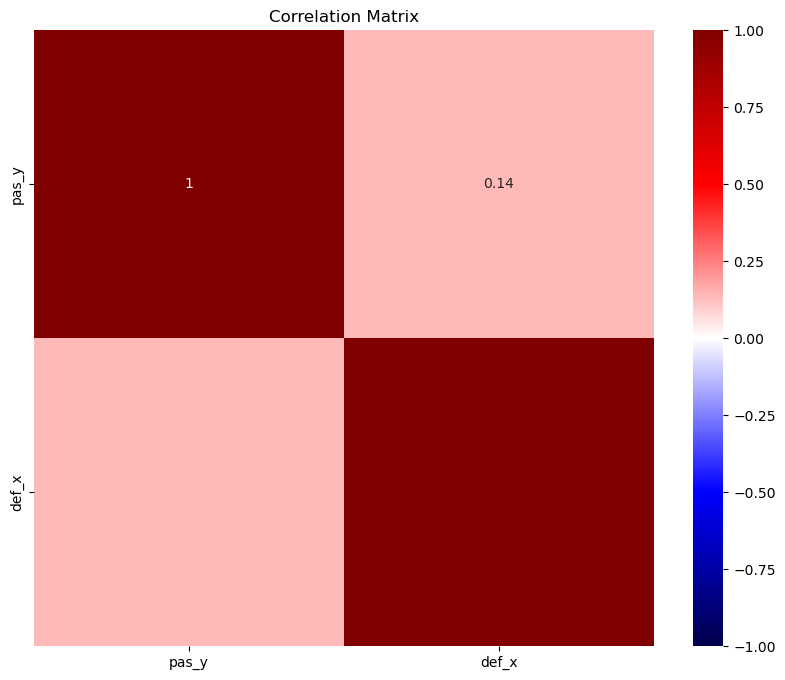

In [164]:
corr_matrix = reg_df[["pas_y","def_x"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()